<a href="https://colab.research.google.com/github/Alepescinaa/ScientificTools/blob/main/Project1/Cp1/Checkpoint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checkpoint 1

Implement here your algorithm to interpolate/extrapolate the activation time field from timings recorded in the 20 electrodes of the mapping catheter.

The algorithm should output the following information:
- a reconstruction of the activation times evaluated at each point of a structured grid on the square (-1.5, 1.5)x(-1.5, 1.5),
- an approximation of the conduction velocity (a clinical biomarker) evaluated at each point of a structured grid on the same square.


## **Data loading**

In [14]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [15]:
!git clone https://github.com/Alepescinaa/ScientificTools
%cd ScientificTools/Project1/Cp1

Cloning into 'ScientificTools'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 306 (delta 42), reused 1 (delta 1), pack-reused 156
Receiving objects: 100% (306/306), 59.84 MiB | 8.58 MiB/s, done.
Resolving deltas: 100% (80/80), done.
/content/ScientificTools/Project1/Cp1/ScientificTools/Project1/Cp1


In [16]:
# loading of the dataset
CP1data = np.load("CP1data.npz")
CP1data = CP1data['arr_0']
len(CP1data)

100

## **Display one recording**

In [91]:
ind_disp = 4
x_meas = CP1data[ind_disp][0]
y_meas = CP1data[ind_disp][1]
t_meas = CP1data[ind_disp][2]

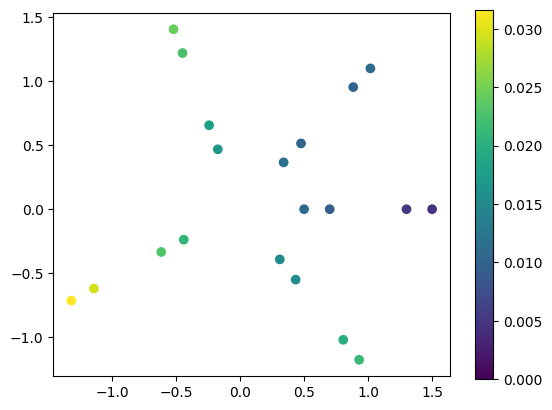

In [18]:
# Display a sample
plt.figure(1)
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(t_meas) )
plt.gca().set_aspect(1)
plt.colorbar()

## **New mesh definition**

In [19]:
X, Y = np.meshgrid(np.linspace(-1.5,1.5,1501), np.linspace(-1.5,1.5,1501))

## **Signature of the function**

def checkpoint1_solution( x, y , t, X , Y ):

return time_pred,vel_pred



In [ ]:
from scipy.interpolate import griddata

def checkpoint1_solution( x, y , t, X , Y ):

    time_pred = griddata(list(zip(x, y)), t, (X, Y), method='nearest')

    grad_AT = np.gradient(time_pred)

    vel_pred = 1.0/( np.sqrt((grad_AT[0]/(3.0/1500))**2+(grad_AT[1]/(3.0/1500))**2) + 1e-4)

    return time_pred,vel_pred

time_pred,vel_pred = checkpoint1_solution( x_meas, y_meas , t_meas, X , Y )

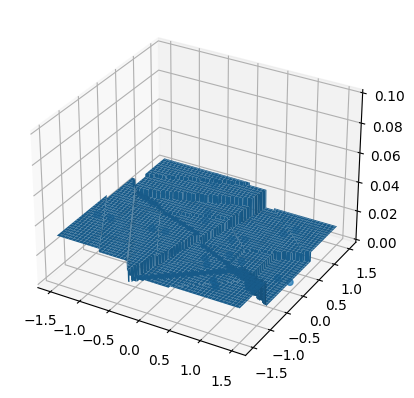

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,time_pred)
ax.axes.set_zlim3d(bottom=0, top=0.1)
ax.scatter3D(x_meas, y_meas, t_meas)

## **SPLINES**
A smoothing spline model for regression is a flexible non-parametric regression technique used for modeling the relationship between a response variable(time) and one or more predictor variables (position). It involves fitting a smooth curve to the observed data while penalizing roughness to avoid overfitting. λ is the smoothing parameter, a larger λ results in a smoother curve with less emphasis on fitting the data exactly. Since we have a small number of  observation (100) wer can exploit leave-one-out cross-validation (LOOCV) to choose an appropriate smoothing parameter.   

I choose splines of order 3 that means

*   polynomilas of order 2 at each interval
*   continuity at knots
-continuity of derivatives

-> so we can directly derive to get velocity conduction

**comments on the code**

We use bisplrep and bisplev to interpolate a 3D surface, kx and ky are the degree of the splines in the x and y axis respectively.

In [ ]:
from scipy.interpolate import bisplrep, bisplev

def checkpoint1_solution(x, y, t, X, Y, s_value):
    # Create a B-spline representation of the data
    tck = bisplrep(x, y, t, s=s_value, kx=2, ky=2)

    # Evaluate the B-spline on the grid
    points_pred = bisplev(X[0, :], Y[:, 0], tck)

    # Extract the activation time predictions
    time_pred = points_pred

    # Compute the gradient of activation time using the B-spline derivatives
    grad_x = bisplev(X[0, :], Y[:, 0], tck, dx=1, dy=0)
    grad_y = bisplev(X[0, :], Y[:, 0], tck, dx=0, dy=1)

    vel_pred = 1.0/( np.sqrt((grad_x/(3.0/1500))**2+(grad_y/(3.0/1500))**2) + 1e-4)
    return time_pred, vel_pred

In [ ]:
time_pred,vel_pred = checkpoint1_solution(x_meas, y_meas, t_meas, X, Y, 0.0072)

## **RADIAL BASIS FUNCTIONS**

Notes:
* neighbors=value of the interpolant at each evaluation point will be computed using only this many nearest data points. (default whole domain)
* epsilon= sets the shape parameter of the radial basis functions. A smaller epsilon results in a more localized influence of each data point, similar to a smaller bandwidth in kernel density estimation.
* smoothing= penalization parameter
* degree= degree of the added polynomial (default for this kernel is 1 -> we should have differentiability)

In [ ]:
from scipy.interpolate import RBFInterpolator

def checkpoint1_solution_radial(x, y, t, X, Y, s_value=0.0072, s_aniso_1=0.5, s_aniso_2=0.5):
    coordinates = np.column_stack((x, y))

    mesh_coordinates=np.column_stack((X.ravel(), Y.ravel()))

    s = [s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_aniso_1, s_value,s_value,s_value,s_value, s_aniso_2,s_value,s_value,s_value,s_value]

    rbf = RBFInterpolator(coordinates, t, neighbors=None, smoothing=s, kernel='thin_plate_spline', epsilon=None, degree=1)

    time_pred = rbf(mesh_coordinates)
    time_pred=time_pred.reshape(1501,1501)

    grad_x, grad_y = np.gradient(time_pred)

    vel_pred = 1.0/( np.sqrt((grad_x/(3.0/1500))**2+(grad_y/(3.0/1500))**2) + 1e-4)

    return time_pred, vel_pred

In [ ]:
time_pred,vel_pred = checkpoint1_solution_radial(x_meas, y_meas, t_meas, X, Y )

## **RADIAL BASIS FUNCTIONS + VELOCITY CORRECTION**

first version

In [96]:
from scipy.interpolate import RBFInterpolator

def checkpoint1_solution_radial1(x, y, t, X, Y, s_value=0.05, s_aniso_1=0.5, s_aniso_2=0.5):
    coordinates = np.column_stack((x, y))

    mesh_coordinates=np.column_stack((X.ravel(), Y.ravel()))

    s = [s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_aniso_1, s_value,s_value,s_value,s_value, s_aniso_2,s_value,s_value,s_value,s_value]

    rbf = RBFInterpolator(coordinates, t, neighbors=None, smoothing=s, kernel='thin_plate_spline', epsilon=None, degree=1)

    time_pred = rbf(mesh_coordinates)
    time_pred=time_pred.reshape(1501,1501)


    grad_x, grad_y = np.gradient(time_pred)

    vel_pred = 1.0/( np.sqrt((grad_x/(3.0/1500))**2+(grad_y/(3.0/1500))**2) + 1e-4)
    treshold=160
    if np.max(vel_pred)>treshold:
      source_indices = np.where(time_pred < 1e-2)
      indices_2d = np.array(source_indices).T
      vel_pred[indices_2d[:, 0],indices_2d[:, 1]] = 1.0/( np.sqrt((grad_x[indices_2d[:, 0],indices_2d[:, 1]]/(3.0/1500))**2+(grad_y[indices_2d[:, 0],indices_2d[:, 1]]/(3.0/1500))**2) + 1e-3)
      vel_pred=vel_pred*(vel_pred<treshold)+treshold*(vel_pred>treshold)

    return time_pred, vel_pred

In [102]:
from scipy.interpolate import RBFInterpolator

def checkpoint1_solution_radial1bis(x, y, t, X, Y, s_value=0.05, s_aniso_1=0.5, s_aniso_2=0.5):
    coordinates = np.column_stack((x, y))

    mesh_coordinates=np.column_stack((X.ravel(), Y.ravel()))

    s = [s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_aniso_1, s_value,s_value,s_value,s_value, s_aniso_2,s_value,s_value,s_value,s_value]

    rbf = RBFInterpolator(coordinates, t, neighbors=None, smoothing=s, kernel='thin_plate_spline', epsilon=None, degree=1)

    time_pred = rbf(mesh_coordinates)
    time_pred=time_pred.reshape(1501,1501)



    grad_x, grad_y = np.gradient(time_pred)

    vel_pred = 1.0/( np.sqrt((grad_x/(3.0/1500))**2+(grad_y/(3.0/1500))**2) + 1e-4)
    treshold=160
    if np.max(vel_pred)>treshold:
      source_indices = np.where(vel_pred >treshold)
      indices_2d = np.array(source_indices).T
      vel_pred[indices_2d[:, 0],indices_2d[:, 1]] = 1.0/( np.sqrt((grad_x[indices_2d[:, 0],indices_2d[:, 1]]/(3.0/1500))**2+(grad_y[indices_2d[:, 0],indices_2d[:, 1]]/(3.0/1500))**2) + 1e-3)
      vel_pred=vel_pred*(vel_pred<treshold)+treshold*(vel_pred>treshold)

    return time_pred, vel_pred

In [103]:
time_pred,vel_pred = checkpoint1_solution_radial1bis(x_meas, y_meas, t_meas, X, Y )

In [100]:
len(source_indices[0])

280736

In [104]:
len(source_indices[0])

129241

second version

In [ ]:
from scipy.interpolate import RBFInterpolator

def checkpoint1_solution_radial2(x, y, t, X, Y, s_value=0.0072, s_aniso_1=0.5, s_aniso_2=0.5):
    coordinates = np.column_stack((x, y))

    mesh_coordinates=np.column_stack((X.ravel(), Y.ravel()))

    s = [s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_value,s_aniso_1, s_value,s_value,s_value,s_value, s_aniso_2,s_value,s_value,s_value,s_value]

    rbf = RBFInterpolator(coordinates, t, neighbors=None, smoothing=s, kernel='thin_plate_spline', epsilon=None, degree=1)

    time_pred = rbf(mesh_coordinates)
    time_pred=time_pred.reshape(1501,1501)

    diff_x = np.diff(time_pred, axis=0)
    diff_y = np.diff(time_pred, axis=1)
    diff_indices_x = np.where(np.abs(diff_x) < 1e-6)
    diff_indices_y = np.where(np.abs(diff_y) < 1e-6)
    diff_all = np.concatenate((diff_indices_x, diff_indices_y), axis=1)
    diff_all = np.array(diff_all).T

    grad_x, grad_y = np.gradient(time_pred)

    vel_pred = 1.0/( np.sqrt((grad_x/(3.0/1500))**2+(grad_y/(3.0/1500))**2) + 1e-4)
    vel_pred[diff_all[:,0], diff_all[:,1]] = 1.0/( np.sqrt((grad_x[  diff_all[:,0], diff_all[:,1]]/(3.0/1500))**2+(grad_y[ diff_all[:,0], diff_all[:,1]]/(3.0/1500))**2) + 1e-3)


    return time_pred, vel_pred

In [ ]:
time_pred,vel_pred = checkpoint1_solution_radial2(x_meas, y_meas, t_meas, X, Y )

## **GAUSSIAN PROCESS**

Notes:

*   length_scale = parameter which control the range over which nearby points influence each other
*   n_restart_optimizer = number of times the optimization procedure is performed to maximize the likelihood of the hyperparameters of the kernel function





In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def checkpoint1_solution( x, y , t, X , Y, len_scale):

    kernel = RBF(length_scale=len_scale)

    gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=1)

    gp.fit(np.column_stack((x, y)), t)

    new_coordinate = np.column_stack((X.ravel(), Y.ravel()))

    time_pred = gp.predict(new_coordinate)

    # Reshape the predictions and uncertainty estimates
    time_pred = time_pred.reshape(X.shape)

    grad_AT = np.gradient(time_pred)

    vel_pred = 1.0/( np.sqrt((grad_AT[0]/(3.0/1500))**2+(grad_AT[1]/(3.0/1500))**2) + 1e-4)

    return time_pred, vel_pred

In [ ]:
time_pred,vel_pred = checkpoint1_solution(x_meas, y_meas, t_meas, X, Y, 0.2)

##  **KRIGING METHOD**

In [13]:

!pip install pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 854.9/854.9 kB 7.3 MB/s eta 0:00:00


In [20]:

! pip install scikit-gstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.3/708.3 kB 6.3 MB/s eta 0:00:00


In [ ]:
from skgstat import DirectionalVariogram
Exp_Variogram= DirectionalVariogram(coordinates=np.column_stack((x_meas, y_meas)), values=t_meas, estimator='matheron', model='spherical', dist_func='euclidean',
                                   bin_func='even', normalize=False, fit_method='trf', fit_sigma=None, directional_model='triangle', azimuth=45, tolerance=45.0,
                                   bandwidth='q33', use_nugget=False, maxlag=None, n_lags=10)
Exp_Variogram.plot()

In [47]:
from pykrige import OrdinaryKriging

variogram_model=linear, power, gaussian, spherical, exponential, hole-effect
variogram_parameters=
if linear
    [slope, nugget]
if power
    [scale, exponent, nugget]
if gaussian, spherical, exponential and hole-effect:
    [sill, range, nugget]

In [54]:
model=OrdinaryKriging(x_meas, y_meas, t_meas, variogram_model='spherical', variogram_parameters=None, variogram_function=None, nlags=6, weight=False,
                           anisotropy_scaling=1.0, anisotropy_angle=0.0, verbose=False, enable_plotting=False, enable_statistics=False,
                           coordinates_type='euclidean', exact_values=True, pseudo_inv=False, pseudo_inv_type='pinv')

time_pred2=model.execute('grid', X[0], Y[:,0])

## **Evaluation**


### Mse_total for all patients

In [ ]:
import numpy as np


mse = np.zeros(100)
mse_sq = np.zeros(100)

for p in range(100):
    x_meas = CP1data[p][0]
    y_meas = CP1data[p][1]
    t_meas = CP1data[p][2]

    time_pred, vel_pred = checkpoint1_solution_radial1(x_meas, y_meas, t_meas, X, Y)

    for k in range(20):
        i, j = np.where((X == x_meas[k]) & (Y == y_meas[k]))
        mse[p] += (time_pred[i, j] - t_meas[k]) ** 2

    mse_sq[p] = np.sqrt(mse[p]/20)

print(np.mean(mse_sq))


### Display of one observation

Activation map of time

<Figure size 640x480 with 0 Axes>

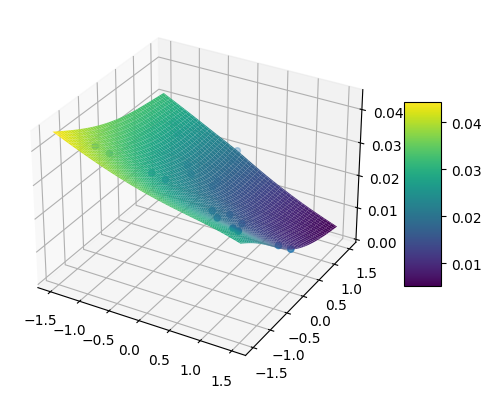

In [72]:
plt.figure()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X,Y,time_pred, cmap = 'viridis')
ax.scatter3D(x_meas, y_meas, t_meas)
ax.axes.set_zlim3d(bottom=0, top=np.max(time_pred))
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

Activation map of velocity

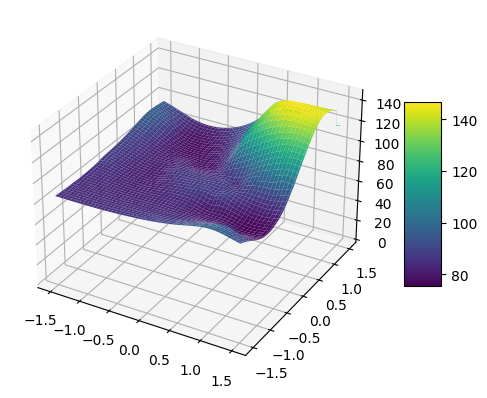

In [56]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X,Y,vel_pred, cmap='viridis')
ax.axes.set_zlim3d(bottom=0, top=np.max(vel_pred))
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

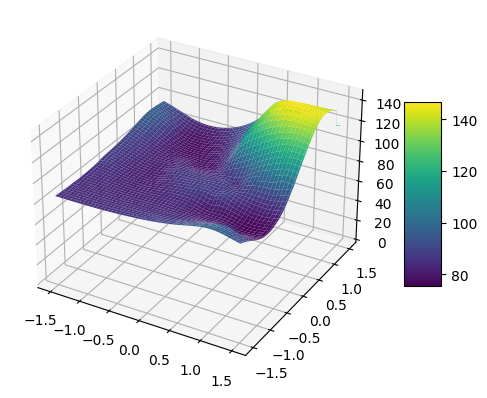

In [57]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X,Y,vel_pred, cmap='viridis')
ax.axes.set_zlim3d(bottom=0, top=np.max(vel_pred))
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

### Velocity map of all observation comparing different versions

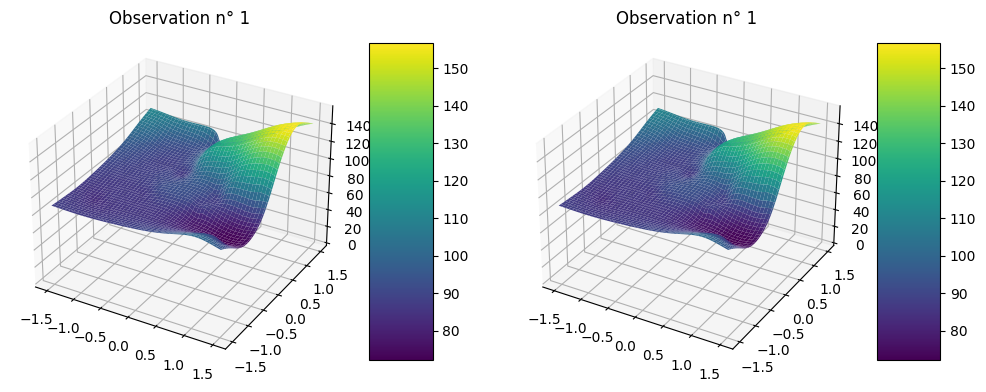

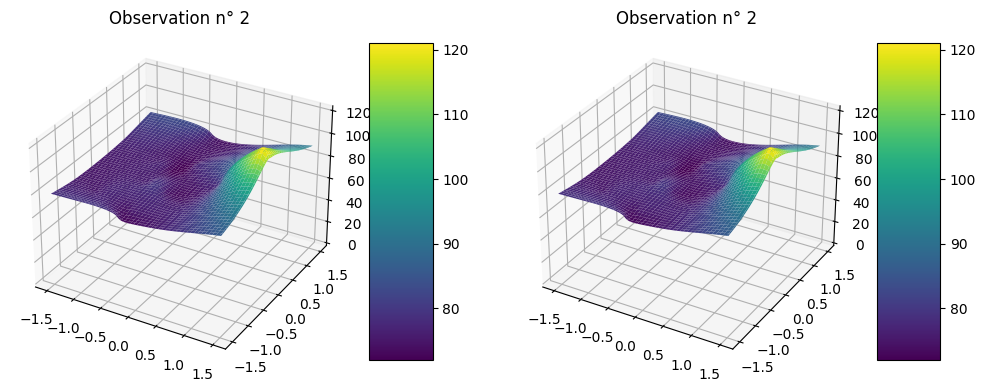

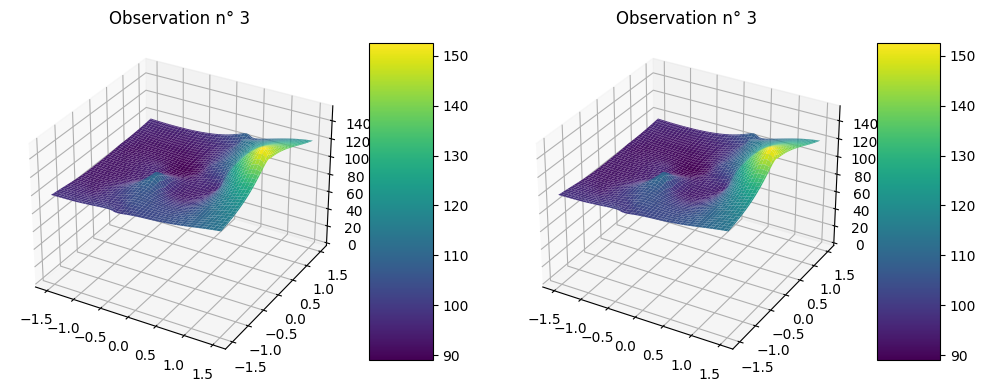

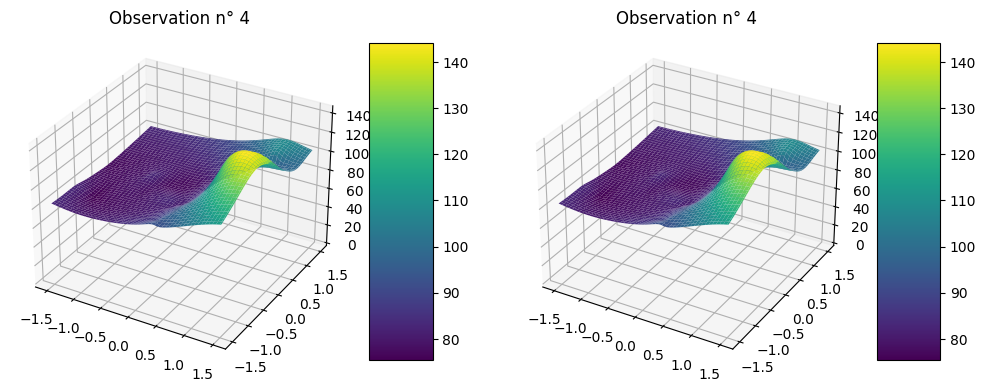

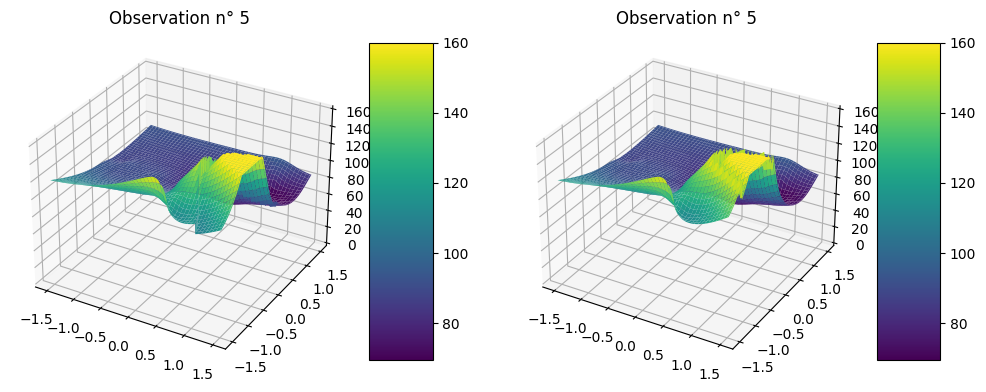

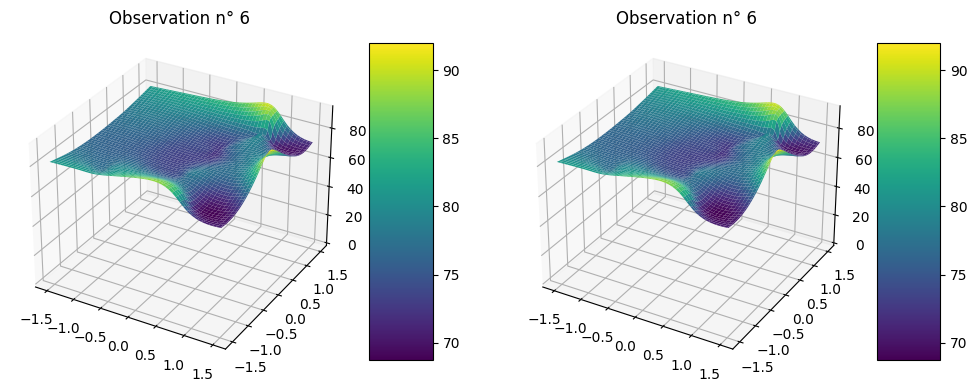

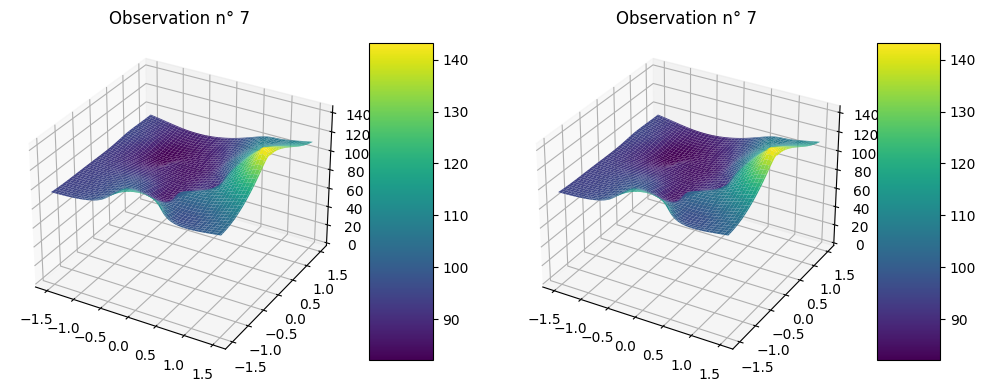

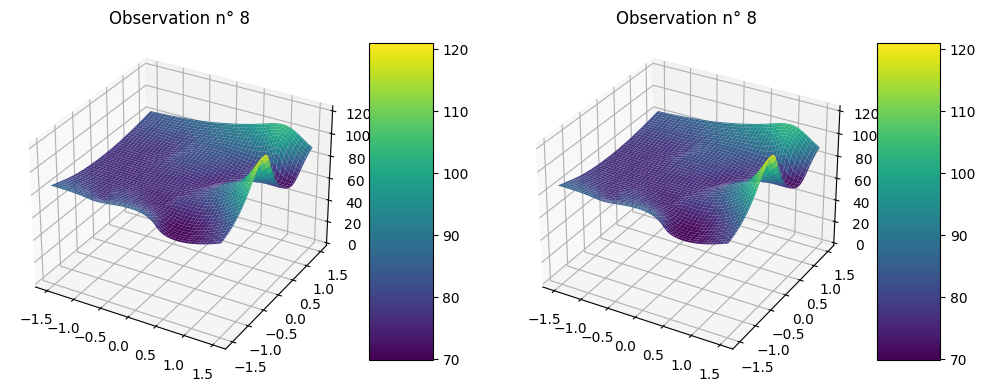

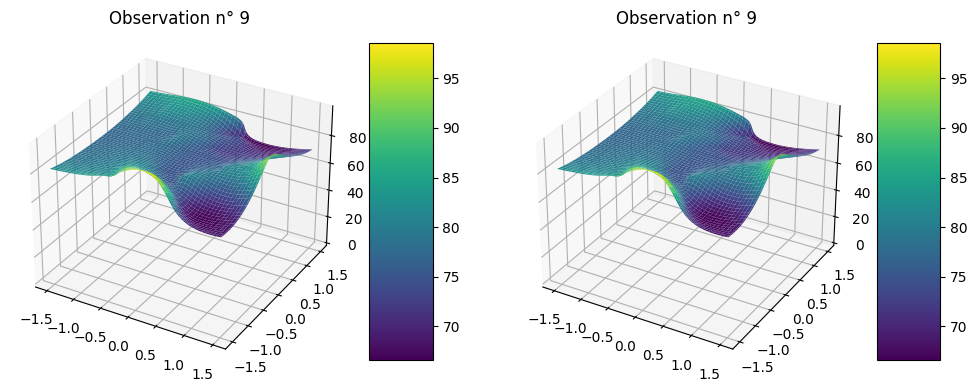

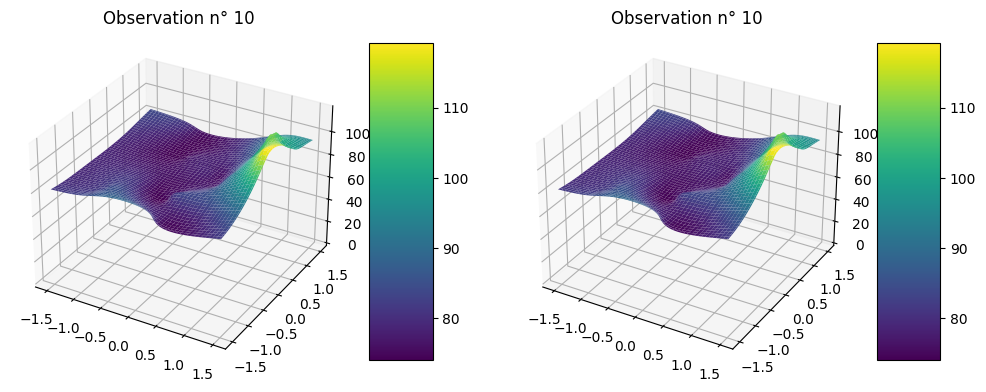

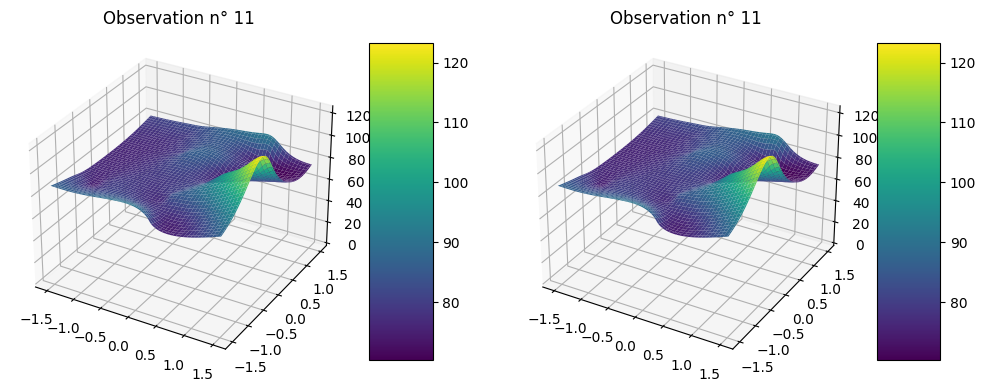

KeyboardInterrupt: 

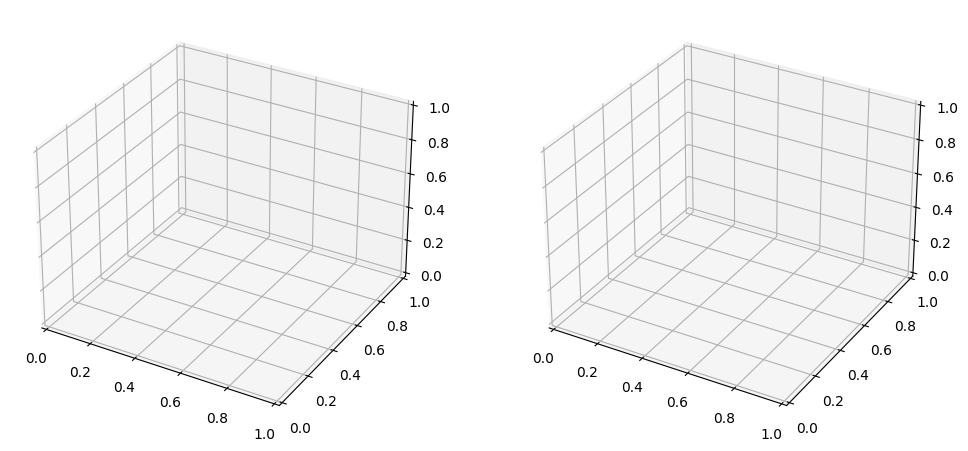

In [90]:
for i in range(100):
  x_meas = CP1data[i][0]
  y_meas = CP1data[i][1]
  t_meas = CP1data[i][2]

  fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize = (12,16))


  time_pred1,vel_pred1 = checkpoint1_solution_radial1(x_meas, y_meas, t_meas, X, Y)

  surf = ax[0].plot_surface(X,Y,vel_pred1, cmap='viridis')
  ax[0].axes.set_zlim3d(bottom=0, top=np.max(vel_pred1))
  fig.colorbar(surf, ax=ax[0], shrink=0.5, aspect=5)
  ax[0].set_title(f'Observation n° {i + 1}')


  time_pred1,vel_pred1 = checkpoint1_solution_radial1bis(x_meas, y_meas, t_meas, X, Y)

  surf = ax[1].plot_surface(X,Y,vel_pred1, cmap='viridis')
  ax[1].axes.set_zlim3d(bottom=0, top=np.max(vel_pred1))
  fig.colorbar(surf, ax=ax[1], shrink=0.5, aspect=5)
  ax[1].set_title(f'Observation n° {i + 1}')

  plt.show()

### Max value of the velocity per patient

In [ ]:
count_over=0.0
for k in range(100):
  x_meas = CP1data[k][0]
  y_meas = CP1data[k][1]
  t_meas = CP1data[k][2]
  time_pred,vel_pred = checkpoint1_solution_radial1(x_meas, y_meas, t_meas, X, Y)

  vel_max = np.max(vel_pred)
  i, j = np.where(vel_pred == vel_max)
  print(f"Max value of velocity per patient {k+1} is at point {i}{j} with value {vel_max}")
  if vel_max > 150:
        count_over += 1
count_over

with velocity correction version 1 and  extra smoothing

In [68]:
count_over=0.0
for k in range(100):
  x_meas = CP1data[k][0]
  y_meas = CP1data[k][1]
  t_meas = CP1data[k][2]
  time_pred,vel_pred = checkpoint1_solution_radial1(x_meas, y_meas, t_meas, X, Y)

  vel_max = np.max(vel_pred)
  i, j = np.where(vel_pred == vel_max)
  print(f"Max value of velocity per patient {k+1} is at point {i}{j} with value {vel_max}")
  if vel_max > 150:
        count_over += 1
count_over

Max value of velocity per patient 1 is at point [1211][1489] with value 152.61210067026968
Max value of velocity per patient 2 is at point [758][1439] with value 120.29894109048503
Max value of velocity per patient 3 is at point [759][1439] with value 151.3076350270353
Max value of velocity per patient 4 is at point [635][1362] with value 142.4706980455928
Max value of velocity per patient 5 is at point [499][1499] with value 221.76715682638883
Max value of velocity per patient 6 is at point [1499][1058] with value 89.38473317284024
Max value of velocity per patient 7 is at point [759][1435] with value 141.3781661044967
Max value of velocity per patient 8 is at point [663][1500] with value 106.98460655499527
Max value of velocity per patient 9 is at point [0][824] with value 98.90596454400425
Max value of velocity per patient 10 is at point [909][1359] with value 107.28012128686225
Max value of velocity per patient 11 is at point [663][1415] with value 116.03882498611316
Max value of v

19.0

with velocity correction version 2 and  extra smoothing

In [69]:
count_over=0
for k in range(100):
  x_meas = CP1data[k][0]
  y_meas = CP1data[k][1]
  t_meas = CP1data[k][2]
  time_pred,vel_pred = checkpoint1_solution_radial2(x_meas, y_meas, t_meas, X, Y)

  vel_max = np.max(vel_pred)
  i, j = np.where(vel_pred == vel_max)
  print(f"Max value of velocity per patient {k+1} is at point {i}{j} with value {vel_max}")
  if vel_max > 150:
        count_over += 1
count_over

NameError: name 'checkpoint1_solution_radial2' is not defined

### Display of activation maps overlapped to a specific observation

In [ ]:
#need to swap the rows of the matrix of times if we want to use imshow matching the values of the time with the right (X,Y)
num_rows = time_pred.shape[0]
for i in range(num_rows // 2):
    time_pred[i], time_pred[num_rows - 1 - i] = time_pred[num_rows - 1 - i], time_pred[i].copy()

Text(0.5, 1.0, 'Observation n° 38')

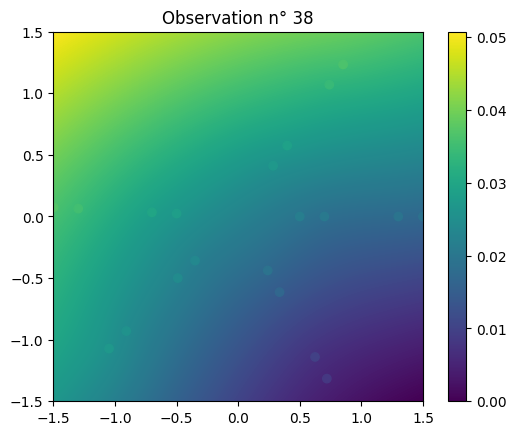

In [ ]:
plt.figure(1)
plt.imshow(time_pred, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)])
plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(time_pred))
plt.gca().set_aspect(1)
plt.colorbar()
plt.title(f'Observation n° {ind_disp + 1}')

### Display of activation maps overlapped to all observation

In [75]:
for i in range(100):
  x_meas = CP1data[i][0]
  y_meas = CP1data[i][1]
  t_meas = CP1data[i][2]

  final_best_s = 0.0072
  time_pred,vel_pred = checkpoint1_solution_radial1(x_meas, y_meas, t_meas, X, Y, final_best_s)

  num_rows = time_pred.shape[0] #need to swap the rows of the matrix of times if we want to use imshow matching the values of the time with the right (X,Y)
  for j in range(num_rows // 2):
    time_pred[j], time_pred[num_rows - 1 - j] = time_pred[num_rows - 1 - j], time_pred[j].copy()

  plt.imshow(time_pred, extent=[np.min(X), np.max(X), np.min(Y), np.max(Y)])
  plt.scatter( x_meas,  y_meas, c=t_meas, vmin= 0, vmax=np.max(time_pred))
  plt.gca().set_aspect(1)
  plt.title(f'Observation n° {i + 1}')
  plt.colorbar()
  plt.show()

KeyboardInterrupt: 

### Comparing mean over maximum values of velocity in all patients between Anisotropic smoothing parameter and Isotropic smoothing parameter

In [ ]:
vec_vel_max_1 = np.zeros(100)
vec_vel_max_2 = np.zeros(100)
err_v = np.zeros(100)

for k in range(100):
  x_meas = CP1data[k][0]
  y_meas = CP1data[k][1]
  t_meas = CP1data[k][2]

  s1 = 0.0072

  s_aniso_1 = 0.05
  s_aniso_2 = 0.05
  s2 = [0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, 0.0072, s_aniso_1, 0.0072, 0.0072, 0.0072, 0.0072, s_aniso_2, 0.0072, 0.0072, 0.0072, 0.0072]

  time_pred_1,vel_pred_1 = checkpoint1_solution_radial(x_meas, y_meas, t_meas, X, Y, s1)
  time_pred_2,vel_pred_2 = checkpoint1_solution_radial(x_meas, y_meas, t_meas, X, Y, s2)

  vel_max_1 = np.max(vel_pred_1)
  vec_vel_max_1[k] = vel_max_1
  i, j = np.where(vel_pred == vel_max_1)
  #print(f"Max velocity per patient {k+1} is  {vel_max_1} for s = {s1}")

  vel_max_2 = np.max(vel_pred_2)
  vec_vel_max_2[k] = vel_max_2
  i, j = np.where(vel_pred == vel_max_2)
  #print(f"Max velocity per patient {k+1} is  {vel_max_2} for s = {s2}")

  err = np.mean(np.abs(time_pred_1 - time_pred_2)) / np.mean(time_pred_1)
  err_v[k] = err

print(f"Medium max velocity 1 is {np.mean(vec_vel_max_1)}")
print(f"Medium max velocity 2 is {np.mean(vec_vel_max_2)} with {np.mean(err_v) * 100} % error on times")

Medium max velocity 1 is 213.02717623588694
Medium max velocity 2 is 175.1438062703942 with 0.08364172967692814 % error on times


In [ ]:
s_aniso_1, s_aniso_2

(0.05, 0.05)

##**Parameters tuning**

In [ ]:
best_s_values = []  # List to store best s values for each observation
s_values=[0.03, 0.02, 0.01, 0.005]

for index in range(100):

    print(f"Observation {index + 1} / 100")

    x_obs = CP1data[index][0]
    y_obs = CP1data[index][1]
    t_obs = CP1data[index][2]

    best_s = None #is gonna keep track of each observation best parameter
    best_metric = float('inf')

    for s_value in s_values:

        total_mse = 0.0

        for i in range(20):
            x_train = np.delete(x_obs, i)
            y_train = np.delete(y_obs, i)
            t_train = np.delete(t_obs, i)

            x_val = x_obs[i]
            y_val = y_obs[i]
            t_val = t_obs[i]

            time_pred,vel_pred = checkpoint1_solution_radial(x_meas, y_meas, t_meas, X, Y , s_value)

            i, j = np.where((X == x_val) & (Y == y_val))

            mse = ((time_pred[i, j] - t_val)**2)
            total_mse += mse

        avg_mse = total_mse / 20  # Average over all LOOCV folds

        # Update best_s if the current s_value is better
        if avg_mse < best_metric:
            best_metric = avg_mse
            best_s = s_value
    print(f"Best metric for observation {index + 1} is s = {np.sqrt(best_metric)} ")
    print(f"Best s_value for observation {index + 1} is s = {best_s}")
    best_s_values.append(best_s)

In [ ]:
final_best_s = np.mean(best_s_values)
final_best_s